In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from plotnine import *

import os
import sys
sys.path.insert(0, "../")
import db_src
from scipy import stats

def calc_mean_sem(data, group_vals, meas, trunc_zero=True):
    """
    Groups data by group_vals and then calculates mean, standard error
    for each column.
    """
    agg_df = data.groupby(group_vals)[meas].agg(['mean', 'std', 'sem']).reset_index()
    for m in meas:
        agg_df[f'{m}_mean'] = agg_df[m]['mean']
        agg_df[f'{m}_std'] = agg_df[m]['std']
        agg_df[f'{m}_sem'] = agg_df[m]['sem']
        agg_df[f'{m}_ymin'] =  agg_df[f'{m}_mean'] - 2*agg_df[f'{m}_sem']
        if trunc_zero:
            agg_df[f'{m}_ymin'] = np.maximum(0, agg_df[f'{m}_ymin'])
        agg_df[f'{m}_ymax'] =  agg_df[f'{m}_mean'] + 2*agg_df[f'{m}_sem']
    
    agg_df = agg_df.loc[:, agg_df.columns.get_level_values(1) == '']
    agg_df.columns = agg_df.columns.get_level_values(0)
    return agg_df

GROUP_VALS = [    
    'n',
    'p', 
    'eps_dist',
    'heterosked',
    #'r2',
    #'covmethod',
    #'tau',
    #'stau',
    #'gamma',
    'method',
    'estimand',
    'Estimand',
    'facet',
    'facet_v2'
]

In [606]:
days = ['2023-09-23', '2023-09-23', '2023-09-24']
ts = ['21-29-06', '22-24-08', '14-16-57']
data0 = []
for d, t in zip(days, ts):
    df = pd.read_csv(f"../sim_data/lee_sims/{d}/{t}/results.csv")
    data0.append(df)
data0 = pd.concat(data0, axis='index')
data0 = data0.loc[~data0['tauv'].isin([0.2, 5])]

# use oracle SES for plug-in estimator
group_vals = ['n', 'tauv', 'method']
alpha = 0.05
sdata = data0.loc[data0['method'] == 'plugin'].copy()
ses = sdata.groupby(group_vals)['lower_est'].std().head(n=20)
ses.name = 'se'
sdata = pd.merge(sdata, ses, on=group_vals)
sdata['lower_bound'] = sdata['lower_est'] - stats.norm.ppf(1-alpha) * sdata['se']
sdata['upper_bound'] = sdata['upper_est'] + stats.norm.ppf(1-alpha) * sdata['se']
sdata['lower_cov'] = sdata['lower_bound'] <= sdata['lower_estimand']
sdata['upper_cov'] = sdata['upper_bound'] >= sdata['upper_estimand']
sdata['method'] = 'plugin_oracle'
sdata = sdata.drop("se", axis='columns')
data = pd.concat([data0, sdata], axis='index')

In [633]:
METHOD_NAMES = {
    "dual_crossfit_ipw":"Crossfit\nDual",
    "oracle_ipw":"Dual Oracle",
    "plugin":"Naive Plug-in",
    "dual_crossfit_aipw":"Crossfit\nDual (AIPW)",
    "oracle_aipw":"Dual Oracle (AIPW)",
    "nox":"No Covariates",
    'plugin_oracle':"Naive Plug-in\nwith oracle SEs",
}
hlvals = ["Homoskedasticity", r"$\sigma_1 / \sigma_0 =3$", r"$\sigma_0 / \sigma_1 = 3$"]
# heteroskedastic labels
data['hetero_lab'] = data['tauv'].map({1:hlvals[0], 3:hlvals[1], 0.33:hlvals[2]})
data['hetero_lab'] = pd.Categorical(data['hetero_lab'], categories=hlvals, ordered=True)
# labels for intro only
hlvals_intro = ['Homoskedasticity', 'Heteroskedasticity (I)', "Heteroskedasticity (II)"]
data['hetero_lab_intro'] = pd.Categorical(
    data['tauv'].map({1:hlvals_intro[0], 3:hlvals_intro[1], 0.33:hlvals_intro[2]}), 
    categories=hlvals_intro, ordered=True
)

data['nlab'] = data['n'].apply(lambda x: f"n={x}")
nlvals = [f"n={x}" for x in np.sort(data['n'].astype(int).unique())]
data['nlab'] = pd.Categorical(data['nlab'], categories=nlvals, ordered=True)

## Figures 1, 3, 4

#### Figure 1 (Estimand/lower CB curves)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/paper_lee.png


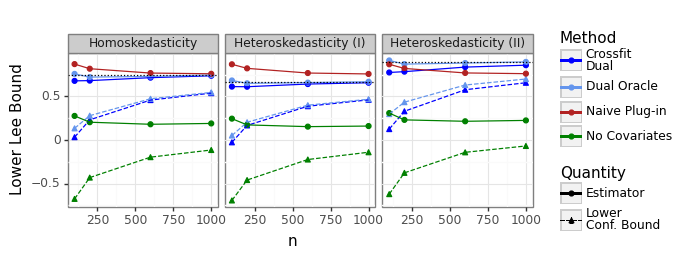

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 3 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/presentation_lee.png


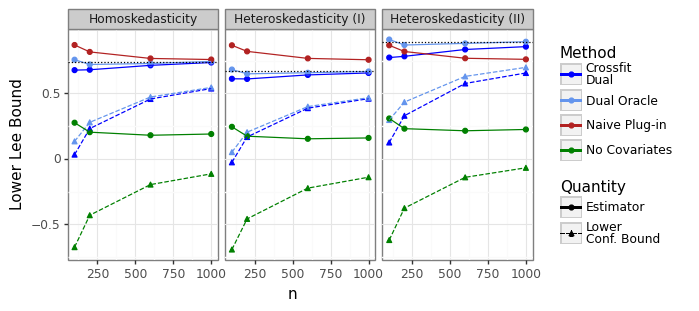

In [648]:
GROUP_VALS = ['n', 'hetero_lab_intro', 'method']
meas = [
    'lower_estimand', 'lower_estimand_nox', 'lower_est',
    'lower_bound', 'lower_cov',
]
data2 = pd.melt(
    data[GROUP_VALS + meas],
    id_vars=GROUP_VALS,
    var_name='meas',
    value_name='val'
)
agg2 = calc_mean_sem(
    data2, 
    group_vals=GROUP_VALS + ['meas'],
    meas=['val']
)
agg2['Meas'] = agg2['meas'].map({
    "lower_estimand":r"$\theta_L$",
    "lower_bound":"Lower\nConf. Bound",#r"$\hat\theta_{LCB}$",
    "lower_est":"Estimator",#r"$\hat\theta_L$"
})
agg2['method'] = agg2['method'].map(METHOD_NAMES)
# plot
for fmt, vlength in zip(['paper', 'presentation'], [2, 3]):
    subagg = agg2.loc[
        (agg2['method'].isin(
            ['Crossfit\nDual', 'No Covariates', 'Naive Plug-in', "Dual Oracle"
        ]))
        & ((agg2['method'] != 'Naive Plug-in') | (agg2['Meas'] != 'Lower\nConf. Bound'))
    ]
    estimand = subagg.loc[subagg['meas'] == 'lower_estimand']
    g = (
        ggplot(
            subagg.loc[subagg['meas'].isin(['lower_est', 'lower_bound'])],
            aes(x='n', y='val_mean', color='method', linetype='Meas', shape='Meas')
        )
        + geom_point(size=1.5)
        + geom_line(alpha=1)
        + facet_grid("~hetero_lab_intro")
        + theme_bw()
        + geom_hline(
            data=estimand,
            mapping=aes(
                yintercept='val_mean', 
                #linetype='Meas'
            ),
            color='black',
            linetype='dotted',
        )
        + theme(figure_size=(6,vlength))
        #+ theme(subplots_adjust={'wspace': 0.18})
        + scale_color_manual(['blue', 'cornflowerblue', 'firebrick', 'green'])
        + scale_linetype_manual(['solid', 'dashed', 'dotted'])
        + labs(
            x='n', 
            y="Lower Lee Bound", 
            color='Method', 
            linetype='Quantity',
            shape='Quantity',
        )
    )
    g.save(f"plots/{fmt}_lee.png", dpi=500)
    print(g)

### Figure 2: coverage (lower)

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 2 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/paper_lee_coverage.png


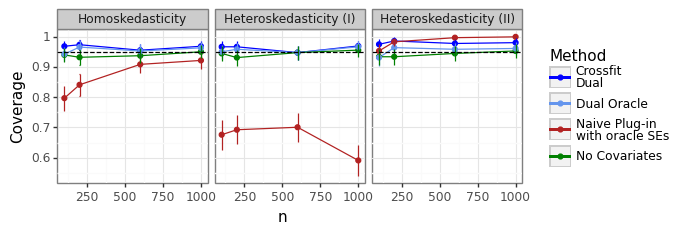

In [642]:
group_vals = ['n', 'hetero_lab_intro', 'method']
agg = calc_mean_sem(
    data,
    group_vals=group_vals,
    meas=['lower_cov']
)
agg['method'] = agg['method'].map(METHOD_NAMES)
meas = 'lower_cov'
sub = agg.loc[
    agg['method'].isin(
        ['Crossfit\nDual', 'Dual Oracle', 'Naive Plug-in\nwith oracle SEs', 'No Covariates'])
]
g = (
    ggplot(
        sub,
        aes(
            x='n',
            color='method', 
            y=f'{meas}_mean',
            ymin=f'{meas}_ymin',
            ymax=f'{meas}_ymax'
        )
    )
    + geom_line()
    + geom_point() 
    + geom_errorbar()
    + geom_hline(yintercept=1-alpha, color='black', linetype='dashed')
    + facet_grid("~hetero_lab_intro")
    + theme_bw()
    + theme(figure_size=(6,2))
    + scale_color_manual(['blue', 'cornflowerblue', 'firebrick', 'green'])
    + labs(x="n", y="Coverage", color='Method')
)
g.save(f"plots/paper_lee_coverage.png", dpi=500)
print(g)

### Figure 4: Violin Plots

In [638]:
mdata = data[['method', 'nlab', 'hetero_lab', 'lower_est', 'upper_est', 'lower_bound', 'upper_bound']].melt(
    id_vars=['nlab', 'method', 'hetero_lab'], var_name='estimator', value_name='value'
)
#mdata = mdata.loc[mdata['method'].isin(['dual_crossfit_ipw', 'oracle_ipw', 'plugin'])]
mdata['upper'] = mdata['estimator'].apply(lambda x: 'Upper' if 'upper' in x else 'Lower')
mdata['bound'] = mdata['estimator'].apply(lambda x: 'est' if 'est' in x else 'bound')
mdata['method'] = mdata['method'].map(METHOD_NAMES)

In [639]:
estimands = data[['nlab', 'hetero_lab', 'lower_estimand', 'upper_estimand']].melt(
    id_vars=['nlab', 'hetero_lab'], value_name='value'
).groupby(['nlab', 'hetero_lab', 'variable'])['value'].mean().reset_index()
estimands['upper'] = estimands['variable'].apply(lambda x: 'Upper' if 'upper' in x else 'Lower')

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/violin_lee_paper.png


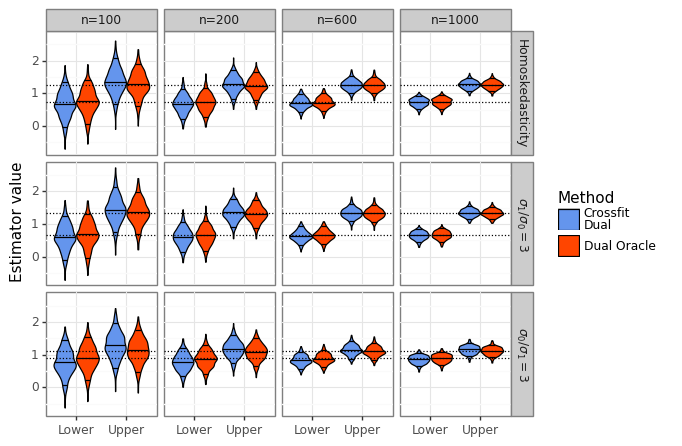

/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 6 x 5 in image.
/home/asher/.local/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: plots/violin_lee_paper.png


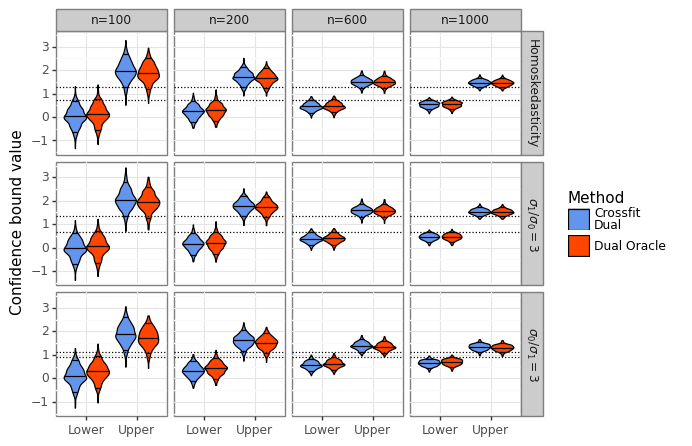

In [640]:
for est_type, name in zip(['est', 'bound'], ['Estimator', 'Confidence bound']):
    sub = mdata.loc[
        (mdata['bound'] == est_type)
        #& (mdata['upper'] != 'Upper')
        & (mdata['method'].str.contains("Dual"))
        & (~mdata['method'].str.contains("AIPW"))
        #& (mdata['tauv'] == tauv)
        #& 
    ]
    est_sub = estimands.loc[
        (estimands['hetero_lab'].isin(sub['hetero_lab'].unique())) &
        (estimands['upper'].isin(sub['upper'].unique()))
    ]
    g = (
        ggplot(
            sub,
            aes(x='upper', y='value', fill='method'),
        ) 
        #+ geom_boxplot()
        + geom_violin(draw_quantiles=(0.05, 0.5, 0.95), color='black')
        + facet_grid("hetero_lab~nlab", scales='free_x')
        + geom_hline(
            data=est_sub, 
            mapping=aes(yintercept='value'), linetype='dotted', 
            color='black'
        )
        + theme_bw()
        + theme(figure_size=(6,5))
        #+ theme(subplots_adjust={"wspace":0.3})
        + labs(x='', y=f'{name} value', fill='Method')
        + scale_fill_manual(['cornflowerblue', 'orangered'])
    )
    g.save(f"plots/violin_lee_paper.png", dpi=500)
    print(g)